<a href="https://colab.research.google.com/github/yatora200403/citrus-orange-disease-detection-20architectures/blob/main/Deteksi_Penyakit_buahjeruk_all_achitecture_batch1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define the requirements

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import time
from pathlib import Path
from sklearn.metrics import confusion_matrix, f1_score, precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, AveragePooling2D, concatenate, MaxPooling2D, Conv2DTranspose, Input, Conv2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [ ]:
# !pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syarif200403","key":"e2c67574b1e1e2ed2d8e00e287dedff5"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'jonathansilva2020/orange-diseases-dataset'

Dataset URL: https://www.kaggle.com/datasets/jonathansilva2020/orange-diseases-dataset
License(s): CC-BY-NC-SA-4.0
 85% 118M/138M [00:00<00:00, 1.23GB/s]
100% 138M/138M [00:00<00:00, 1.15GB/s]


<h2>Extract Dataset</h2>

In [ ]:
# Import library untuk handling zip file
import zipfile

In [ ]:
# Spesifikan  nama file
dataset_zip = zipfile.ZipFile('orange-diseases-dataset.zip','r')

# Extract
dataset_zip.extractall('orange-diseases-dataset')

# Tutup zip file
dataset_zip.close()

# Preprocessing

## change old names and change wrong image format

In [ ]:
from PIL import Image

# Fungsi untuk memuat dan mengubah ukuran gambar menggunakan PIL
def load_and_resize_image(file_path, target_shape=(224, 224)):
    image = Image.open(file_path).convert('RGB')  # Membuka gambar dan mengonversi ke RGB
    resized_image = image.resize(target_shape)   # Mengubah ukuran gambar
    return np.array(resized_image)               # Mengembalikan gambar dalam bentuk array

In [ ]:
# Fungsi untuk memuat gambar dari direktori
def load_image_class_by_directory(image_dir):
    # Daftar file gambar di dalam direktori
    image_files = [file for file in os.listdir(image_dir) if file.lower().endswith('.jpg') or file.lower().endswith('.png')]
    images = [load_and_resize_image(os.path.join(image_dir, file)) for file in image_files]

    print(f"Num of images: {len(images)}")
    print(f"Single image shape before flattening: {images[0].shape}")
    return images

In [ ]:
# Menampilkan beberapa gambar
def display_images(images, num_images_to_display=6):
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 5))
    for i in range(num_images_to_display):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

In [ ]:
# import shutil
# shutil.rmtree('/content/orange-diseases-dataset')

#mengganti nama folder yang tidak sesuai
old_names = ['blackspot', 'canker', 'fresh', 'grenning']
new_names = ['blackspot', 'cancer', 'fresh', 'greening']
train_path = '/content/orange-diseases-dataset/train/'
test_path = '/content/orange-diseases-dataset/test/'
for i,name in enumerate(old_names):
  os.rename(os.path.join(train_path, name), os.path.join(train_path,new_names[i]))
  os.rename(os.path.join(test_path, name), os.path.join(test_path,new_names[i]))

In [ ]:
#convert png to jpg
from PIL import Image

def convert_png_to_jpg(path):
  for filename in os.listdir(path):
    if filename.endswith('.png'):
      img = Image.open(os.path.join(path, filename))
      img = img.convert('RGB')
      img.save(os.path.join(path, os.path.splitext(filename)[0] + '.jpg'))
      os.remove(os.path.join(path, filename))

fresh_train = '/content/orange-diseases-dataset/train/fresh/'
fresh_test = '/content/orange-diseases-dataset/test/fresh/'
convert_png_to_jpg(fresh_train)
convert_png_to_jpg(fresh_test)

Class **1** Sample (Blackspot)

Num of images: 184
Single image shape before flattening: (224, 224, 3)


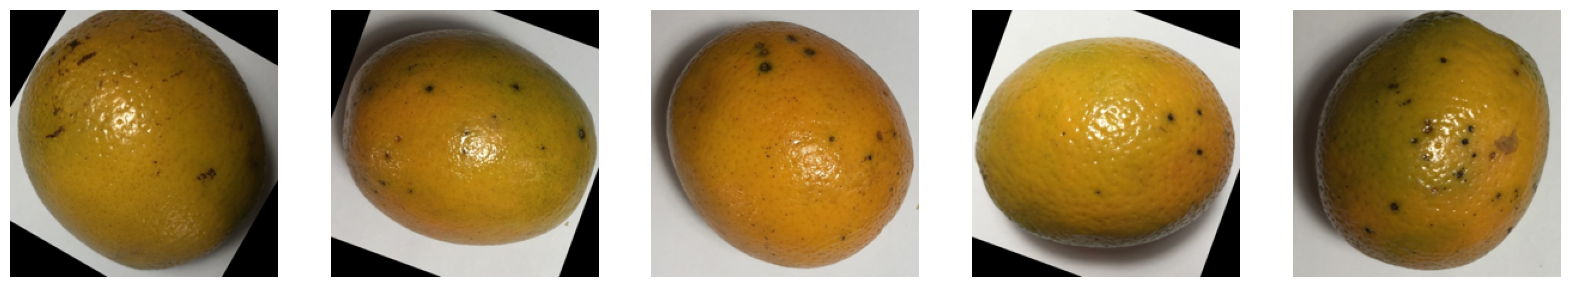

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/blackspot'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

Class 2 Sample (Cancer)

Num of images: 179
Single image shape before flattening: (224, 224, 3)


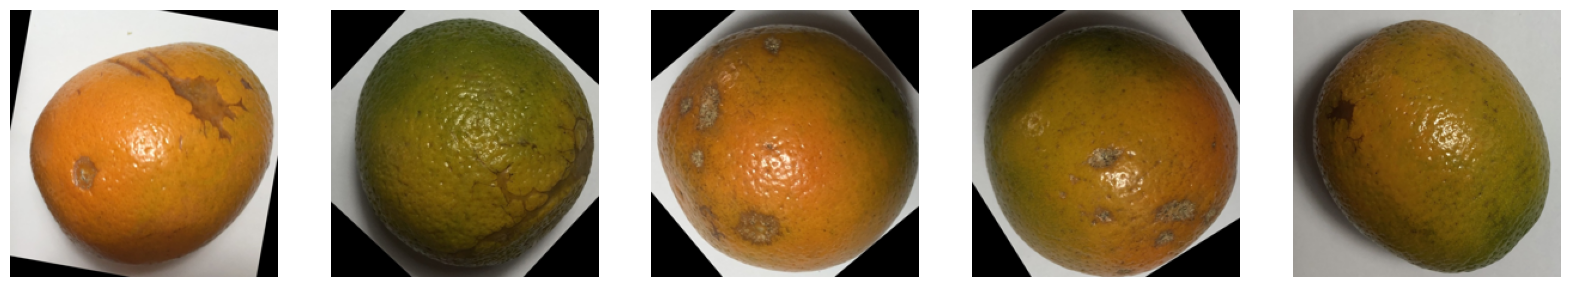

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/cancer'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

Class 3 Sample (Greening)

Num of images: 347
Single image shape before flattening: (224, 224, 3)


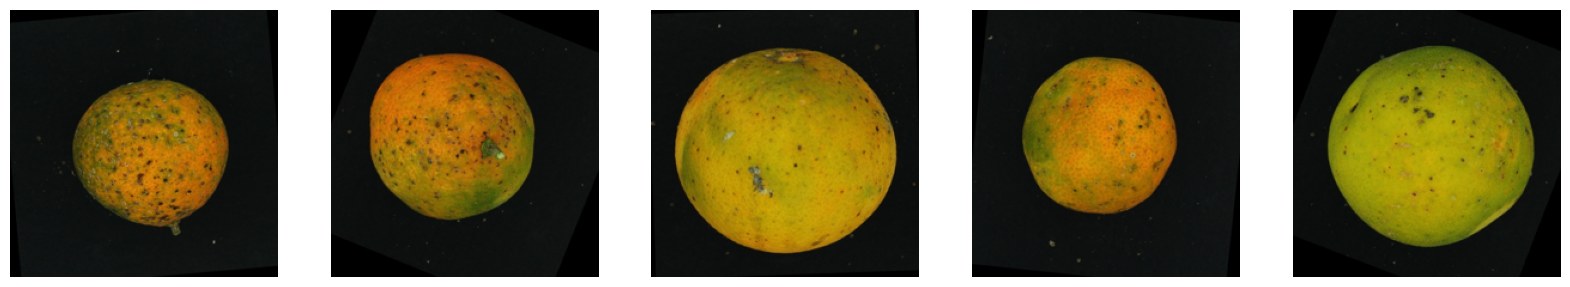

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/greening'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

Class 4 Sample (Fresh)

Num of images: 281
Single image shape before flattening: (224, 224, 3)


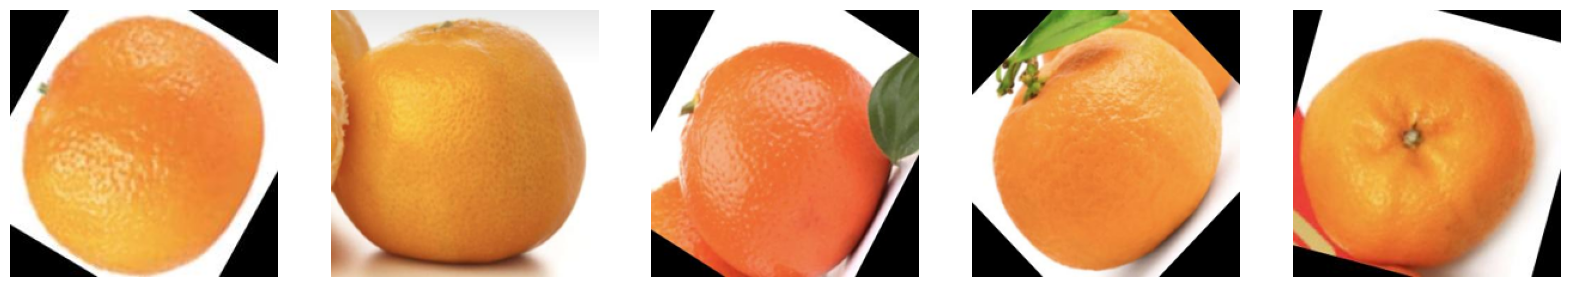

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/fresh'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

In [ ]:
def count_images_in_classes(base_dir):
    # Daftar semua subfolder dalam base_dir
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Iterasi untuk menghitung jumlah gambar setiap kelas
    for class_name in class_dirs:
        class_path = os.path.join(base_dir, class_name)
        # Hitung file dengan ekstensi .jpg atau .png
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith('.jpg') or f.lower().endswith('.png')])
        print(f"Disease: {class_name} --- Images: {num_images}")

# Path menuju direktori dataset
base_dir = '/content/orange-diseases-dataset/train'

count_images_in_classes(base_dir)

Disease: blackspot --- Images: 184
Disease: fresh --- Images: 281
Disease: greening --- Images: 347
Disease: cancer --- Images: 179


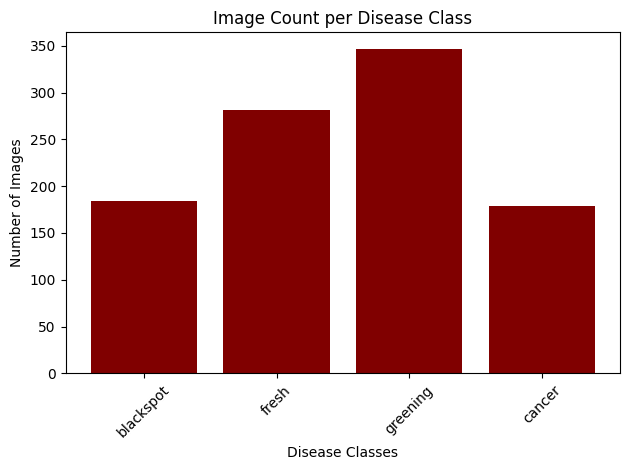

In [ ]:
def count_images_and_plot(base_dir):
    # Hitung jumlah gambar per kelas
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    class_counts = [len([f for f in os.listdir(os.path.join(base_dir, d)) if f.lower().endswith('.jpg') or f.lower().endswith('.png')]) for d in class_dirs]

    # Buat chart
    plt.bar(class_dirs, class_counts, color='maroon')
    plt.xlabel('Disease Classes')
    plt.ylabel('Number of Images')
    plt.title('Image Count per Disease Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Path menuju ke direktori dataset
base_dir = '/content/orange-diseases-dataset/train'

# Hitung dan juga tampilkan chart
count_images_and_plot(base_dir)

## Data Augmentation

In [ ]:
def image_aug(path, img_class:str):
  img_list = []
  for filename in os.listdir(path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
      img = tf.keras.preprocessing.image.load_img(os.path.join(path, filename))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_list.append(img_array)


  datagen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True
  )

  for img in img_list:
    img = img.reshape((1,) + img.shape)
    for batch in datagen.flow(img, batch_size=1, save_to_dir='/content/orange-diseases-dataset/train/'+img_class, save_prefix=img_class, save_format='jpg'):
      if len(os.listdir('/content/orange-diseases-dataset/train/'+img_class)) == 500:
        break
    if len(os.listdir('/content/orange-diseases-dataset/train/'+img_class)) == 500:
      break

disease_classes = ['blackspot','cancer','greening','fresh']
for disease in disease_classes:
  image_aug('/content/orange-diseases-dataset/train/'+disease, disease)

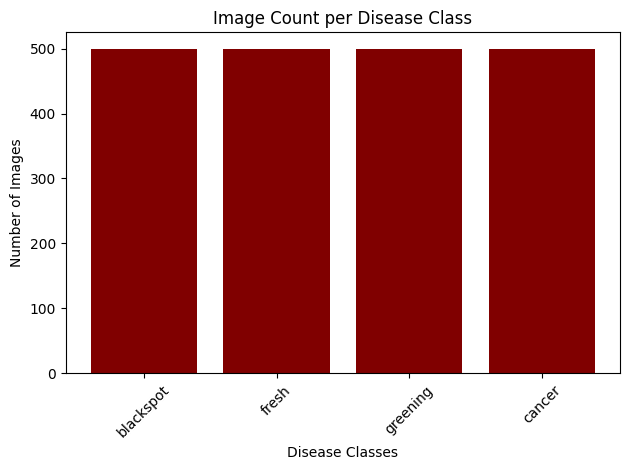

In [ ]:
count_images_and_plot(base_dir)
# plt.imshow(Image.open('/content/orange-diseases-dataset/train/blackspot/blackspot_0_150.jpg'))
# plt.axis('off')
# plt.show()

## Image Normalization

Found 2000 images belonging to 4 classes.
Found 99 images belonging to 4 classes.
Num of images: 500
Single image shape before flattening: (224, 224, 3)


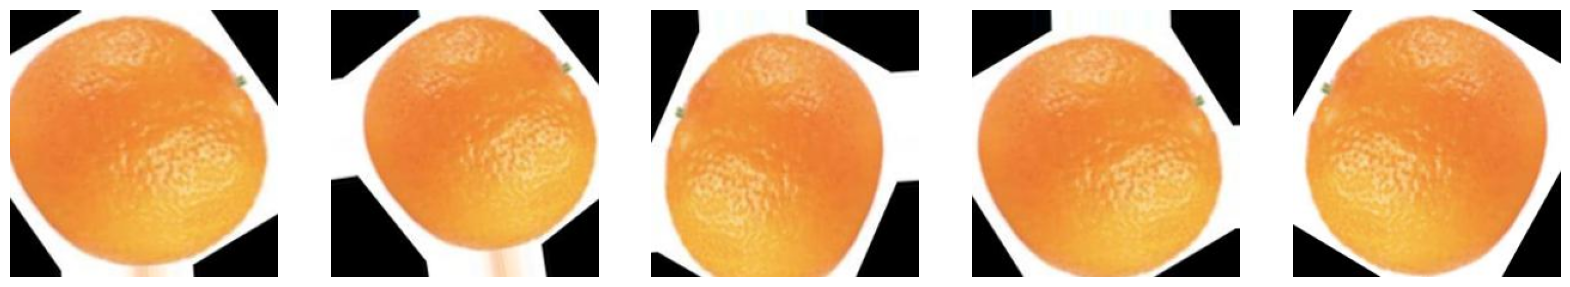

In [ ]:
datagen_normalized = ImageDataGenerator(rescale=1./255)

train_generator_normalized = datagen_normalized.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator_normalized = datagen_normalized.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/fresh'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

## Splitting Dataset into:

<ul>
  <li>training = 70%</li>
  <li>validation = 15%</li>
  <li>test = 15%</li>
</ul>

In [ ]:
dataset_path = Path('/content/orange-diseases-dataset/train')
batch_size = 32
img_size = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
#store all name of disease class names
class_names = train_ds.class_names

# Further split the validation dataset to create a test dataset
val_batches = int(0.5 * val_ds.cardinality().numpy())
valid_ds = val_ds.take(val_batches)
test_ds = val_ds.skip(val_batches)

# Print dataset information
print(f"Training batches: {train_ds.cardinality().numpy()}")
print(f"Validation batches: {valid_ds.cardinality().numpy()}")
print(f"Testing batches: {test_ds.cardinality().numpy()}")


Found 2000 files belonging to 4 classes.
Using 1400 files for training.
Found 2000 files belonging to 4 classes.
Using 600 files for validation.
Training batches: 44
Validation batches: 9
Testing batches: 10


# Training Process

## 1. MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model_mobilenetv2 = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_mobilenetv2.trainable = False

model_mobilenetv2 = tf.keras.Sequential([
    base_model_mobilenetv2,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_mobilenetv2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_mobilenetv2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,632,452 (10.04 MB)

 Trainable params: 371,908 (1.42 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [ ]:
starttime_mobilenetv2 = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_mobilenetv2 = model_mobilenetv2.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_mobilenetv2 = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 318ms/step - accuracy: 0.4641 - loss: 1.2933 - val_accuracy: 0.7882 - val_loss: 0.7636
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - accuracy: 0.8862 - loss: 0.3774 - val_accuracy: 0.8750 - val_loss: 0.3996
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9037 - loss: 0.2463 - val_accuracy: 0.9132 - val_loss: 0.2855
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9273 - loss: 0.1743 - val_accuracy: 0.8958 - val_loss: 0.2136
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9343 - loss: 0.1459 - val_accuracy: 0.9306 - val_loss: 0.1711
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9451 - loss: 0.1202 - val_accuracy: 0.9410 - val_loss: 0.1380
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9611 - loss: 0.1043 - val_accuracy: 0.9514 - val_loss: 0.1172
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9666 - loss: 0.0884 - val_accuracy: 0.94

## 2. MobileNetV3Small

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small


base_model_mobilenetv3small = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_mobilenetv3small.trainable = False

model_mobilenetv3small = tf.keras.Sequential([
    base_model_mobilenetv3small,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_mobilenetv3small.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_mobilenetv3small.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 576)            │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 576)            │         2,304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,130,548 (4.31 MB)

 Trainable params: 190,276 (743.27 KB)

 Non-trainable params: 940,272 (3.59 MB)

In [ ]:
starttime_mobilenetv3small = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_mobilenetv3small = model_mobilenetv3small.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_mobilenetv3small = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 329ms/step - accuracy: 0.5202 - loss: 1.1401 - val_accuracy: 0.8819 - val_loss: 0.7648
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9414 - loss: 0.2888 - val_accuracy: 0.9479 - val_loss: 0.3748
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9622 - loss: 0.1509 - val_accuracy: 0.9688 - val_loss: 0.2113
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9854 - loss: 0.0841 - val_accuracy: 0.9826 - val_loss: 0.1222
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9784 - loss: 0.0661 - val_accuracy: 0.9826 - val_loss: 0.0834
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9883 - loss: 0.0448 - val_accuracy: 0.9896 - val_loss: 0.0515
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.9944 - loss: 0.0359 - val_accuracy: 0.9861 - val_loss: 0.0488
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9922 - loss: 0.0352 - val_accuracy: 0.98

## 3. MobileNetV3Large

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large


base_model_mobilenetv3large = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_mobilenetv3large.trainable = False

model_mobilenetv3large = tf.keras.Sequential([
    base_model_mobilenetv3large,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_mobilenetv3large.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_mobilenetv3large.summary()

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 960)            │         3,840 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,287,620 (12.54 MB)

 Trainable params: 289,348 (1.10 MB)

 Non-trainable params: 2,998,272 (11.44 MB)

In [ ]:
starttime_mobilenetv3large = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_mobilenetv3large = model_mobilenetv3large.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_mobilenetv3large = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 394ms/step - accuracy: 0.6243 - loss: 0.9919 - val_accuracy: 0.9201 - val_loss: 0.6449
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9274 - loss: 0.3190 - val_accuracy: 0.9826 - val_loss: 0.3504
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9609 - loss: 0.1580 - val_accuracy: 0.9896 - val_loss: 0.1912
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9723 - loss: 0.1030 - val_accuracy: 0.9931 - val_loss: 0.1134
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9836 - loss: 0.0703 - val_accuracy: 0.9861 - val_loss: 0.0798
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9880 - loss: 0.0488 - val_accuracy: 1.0000 - val_loss: 0.0417
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9902 - loss: 0.0430 - val_accuracy: 0.9896 - val_loss: 0.0448
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9919 - loss: 0.0333 - val_accuracy: 0.9

## 4. VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

base_model_vgg16 = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_vgg16.trainable = False

model_vgg16 = tf.keras.Sequential([
    base_model_vgg16,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,889,476 (56.80 MB)

 Trainable params: 173,764 (678.77 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [ ]:
starttime_vgg16 = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_vgg16 = model_vgg16.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_vgg16 = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 482ms/step - accuracy: 0.4980 - loss: 1.0951 - val_accuracy: 0.9340 - val_loss: 0.3528
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.9206 - loss: 0.3926 - val_accuracy: 0.9410 - val_loss: 0.1952
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.9401 - loss: 0.2275 - val_accuracy: 0.9653 - val_loss: 0.1176
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.9576 - loss: 0.1461 - val_accuracy: 0.9618 - val_loss: 0.0842
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.9724 - loss: 0.0942 - val_accuracy: 0.9861 - val_loss: 0.0524
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.9741 - loss: 0.0813 - val_accuracy: 0.9861 - val_loss: 0.0468
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.9875 - loss: 0.0579 - val_accuracy: 0.9826 - val_loss: 0.0382
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.9717 - loss: 0.0756 - val_accura

## 5. VGG19

In [ ]:
from tensorflow.keras.applications import VGG19

base_model_vgg19 = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_vgg19.trainable = False

model_vgg19 = tf.keras.Sequential([
    base_model_vgg19,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_vgg19.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,199,172 (77.05 MB)

 Trainable params: 173,764 (678.77 KB)

 Non-trainable params: 20,025,408 (76.39 MB)

In [ ]:
starttime_vgg19 = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_vgg19 = model_vgg19.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_vgg19 = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 324ms/step - accuracy: 0.4188 - loss: 1.5182 - val_accuracy: 0.6910 - val_loss: 0.7464
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - accuracy: 0.8112 - loss: 0.5816 - val_accuracy: 0.9062 - val_loss: 0.3141
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - accuracy: 0.8971 - loss: 0.3369 - val_accuracy: 0.9444 - val_loss: 0.1974
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.9368 - loss: 0.2225 - val_accuracy: 0.9583 - val_loss: 0.1263
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 262ms/step - accuracy: 0.9517 - loss: 0.1663 - val_accuracy: 0.9618 - val_loss: 0.1194
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 243ms/step - accuracy: 0.9475 - loss: 0.1412 - val_accuracy: 0.9861 - val_loss: 0.0769
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.9609 - loss: 0.1094 - val_accuracy: 0.9826 - val_loss: 0.0653
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.9589 - loss: 0.1029 - val_accu

## 6. InceptionResNetV2

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

base_model_inceptionresnetv2 = InceptionResNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_inceptionresnetv2.trainable = False

model_inceptionresnetv2 = tf.keras.Sequential([
    base_model_inceptionresnetv2,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_inceptionresnetv2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_inceptionresnetv2.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 1536)           │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_208         │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,777,764 (208.96 MB)

 Trainable params: 437,956 (1.67 MB)

 Non-trainable params: 54,339,808 (207.29 MB)

In [ ]:
starttime_inceptionresnetv2 = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_inceptionresnetv2 = model_inceptionresnetv2.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_inceptionresnetv2 = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 883ms/step - accuracy: 0.4611 - loss: 1.3488 - val_accuracy: 0.3160 - val_loss: 4.7691
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 185ms/step - accuracy: 0.7166 - loss: 0.8285 - val_accuracy: 0.3785 - val_loss: 2.5251
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.7456 - loss: 0.6923 - val_accuracy: 0.4965 - val_loss: 1.3590
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.7807 - loss: 0.6549 - val_accuracy: 0.6528 - val_loss: 0.7887
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 0.8072 - loss: 0.5711 - val_accuracy: 0.7708 - val_loss: 0.5727
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.8310 - loss: 0.5228 - val_accuracy: 0.8229 - val_loss: 0.4489
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.8139 - loss: 0.5031 - val_accuracy: 0.8160 - val_loss: 0.4456
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.8279 - loss: 0.4565 - val_accuracy

## 7. InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model_inceptionv3 = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_inceptionv3.trainable = False

model_inceptionv3 = tf.keras.Sequential([
    base_model_inceptionv3,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_inceptionv3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_inceptionv3.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_303         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,376,932 (85.36 MB)

 Trainable params: 570,052 (2.17 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [ ]:
starttime_inceptionv3 = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_inceptionv3 = model_inceptionv3.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_inceptionv3 = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 466ms/step - accuracy: 0.5897 - loss: 0.9940 - val_accuracy: 0.6215 - val_loss: 1.3843
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.8929 - loss: 0.3352 - val_accuracy: 0.8021 - val_loss: 0.5524
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9143 - loss: 0.2469 - val_accuracy: 0.8854 - val_loss: 0.2888
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.9103 - loss: 0.2270 - val_accuracy: 0.9306 - val_loss: 0.1867
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9328 - loss: 0.1780 - val_accuracy: 0.9271 - val_loss: 0.1775
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9376 - loss: 0.1431 - val_accuracy: 0.9444 - val_loss: 0.1970
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.9554 - loss: 0.1245 - val_accuracy: 0.9271 - val_loss: 0.1568
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9434 - loss: 0.1401 - val_accuracy: 0.9

## 8. ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model_resnet50 = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_resnet50.trainable = False

model_resnet50 = tf.keras.Sequential([
    base_model_resnet50,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_resnet50.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_304         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,161,860 (92.17 MB)

 Trainable params: 570,052 (2.17 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [ ]:
starttime_resnet50 = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_resnet50 = model_resnet50.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_resnet50 = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 371ms/step - accuracy: 0.5176 - loss: 1.2049 - val_accuracy: 0.8958 - val_loss: 0.4905
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.9560 - loss: 0.2021 - val_accuracy: 0.9688 - val_loss: 0.2158
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9767 - loss: 0.0923 - val_accuracy: 0.9688 - val_loss: 0.1398
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.9867 - loss: 0.0581 - val_accuracy: 0.9826 - val_loss: 0.0886
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9842 - loss: 0.0519 - val_accuracy: 0.9931 - val_loss: 0.0535
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.9945 - loss: 0.0301 - val_accuracy: 0.9931 - val_loss: 0.0480
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9918 - loss: 0.0349 - val_accuracy: 1.0000 - val_loss: 0.0246
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9941 - loss: 0.0232 - val_accuracy

## 9. ResNet50V2

In [ ]:
from tensorflow.keras.applications import ResNet50V2

base_model_resnet50v2 = ResNet50V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_resnet50v2.trainable = False

model_resnet50v2 = tf.keras.Sequential([
    base_model_resnet50v2,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_resnet50v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_resnet50v2.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_305         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,138,948 (92.08 MB)

 Trainable params: 570,052 (2.17 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

In [ ]:
starttime_resnet50v2 = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_resnet50v2 = model_resnet50v2.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_resnet50v2 = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 350ms/step - accuracy: 0.5609 - loss: 1.0156 - val_accuracy: 0.5972 - val_loss: 1.4973
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9011 - loss: 0.3272 - val_accuracy: 0.7361 - val_loss: 0.6409
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.9196 - loss: 0.2227 - val_accuracy: 0.8750 - val_loss: 0.3173
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9352 - loss: 0.1713 - val_accuracy: 0.9340 - val_loss: 0.1609
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.9343 - loss: 0.1520 - val_accuracy: 0.9410 - val_loss: 0.1257
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9378 - loss: 0.1273 - val_accuracy: 0.9375 - val_loss: 0.1180
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9610 - loss: 0.1127 - val_accuracy: 0.9479 - val_loss: 0.0962
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9642 - loss: 0.0910 - val_accuracy: 0.

## 10. ResNet101

In [ ]:
from tensorflow.keras.applications import ResNet101

base_model_resnet101 = ResNet50V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_resnet101.trainable = False

model_resnet101 = tf.keras.Sequential([
    base_model_resnet101,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_resnet101.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_resnet101.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_306         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,138,948 (92.08 MB)

 Trainable params: 570,052 (2.17 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

In [ ]:
starttime_resnet101 = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_resnet101 = model_resnet101.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_resnet101 = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 292ms/step - accuracy: 0.5826 - loss: 0.9775 - val_accuracy: 0.6285 - val_loss: 1.0495
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9008 - loss: 0.3367 - val_accuracy: 0.7986 - val_loss: 0.4337
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9281 - loss: 0.1957 - val_accuracy: 0.9514 - val_loss: 0.1923
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9469 - loss: 0.1547 - val_accuracy: 0.9444 - val_loss: 0.1609
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.9465 - loss: 0.1300 - val_accuracy: 0.9375 - val_loss: 0.1299
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.9532 - loss: 0.1072 - val_accuracy: 0.9514 - val_loss: 0.0985
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9614 - loss: 0.0925 - val_accuracy: 0.9410 - val_loss: 0.1244
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9608 - loss: 0.0950 - val_accuracy: 0

# Training Performace

In [ ]:
number_of_architecture = 10
number_of_column = 2
number_of_row = int(number_of_architecture / number_of_column)
recall_list = []
precision_list = []
f1score_list = []
trainingtime_list = []
accuracy_list = []
val_accuracy_list = []
loss_list = []
val_loss_list = []
epochs_list = []

## training and validation performance

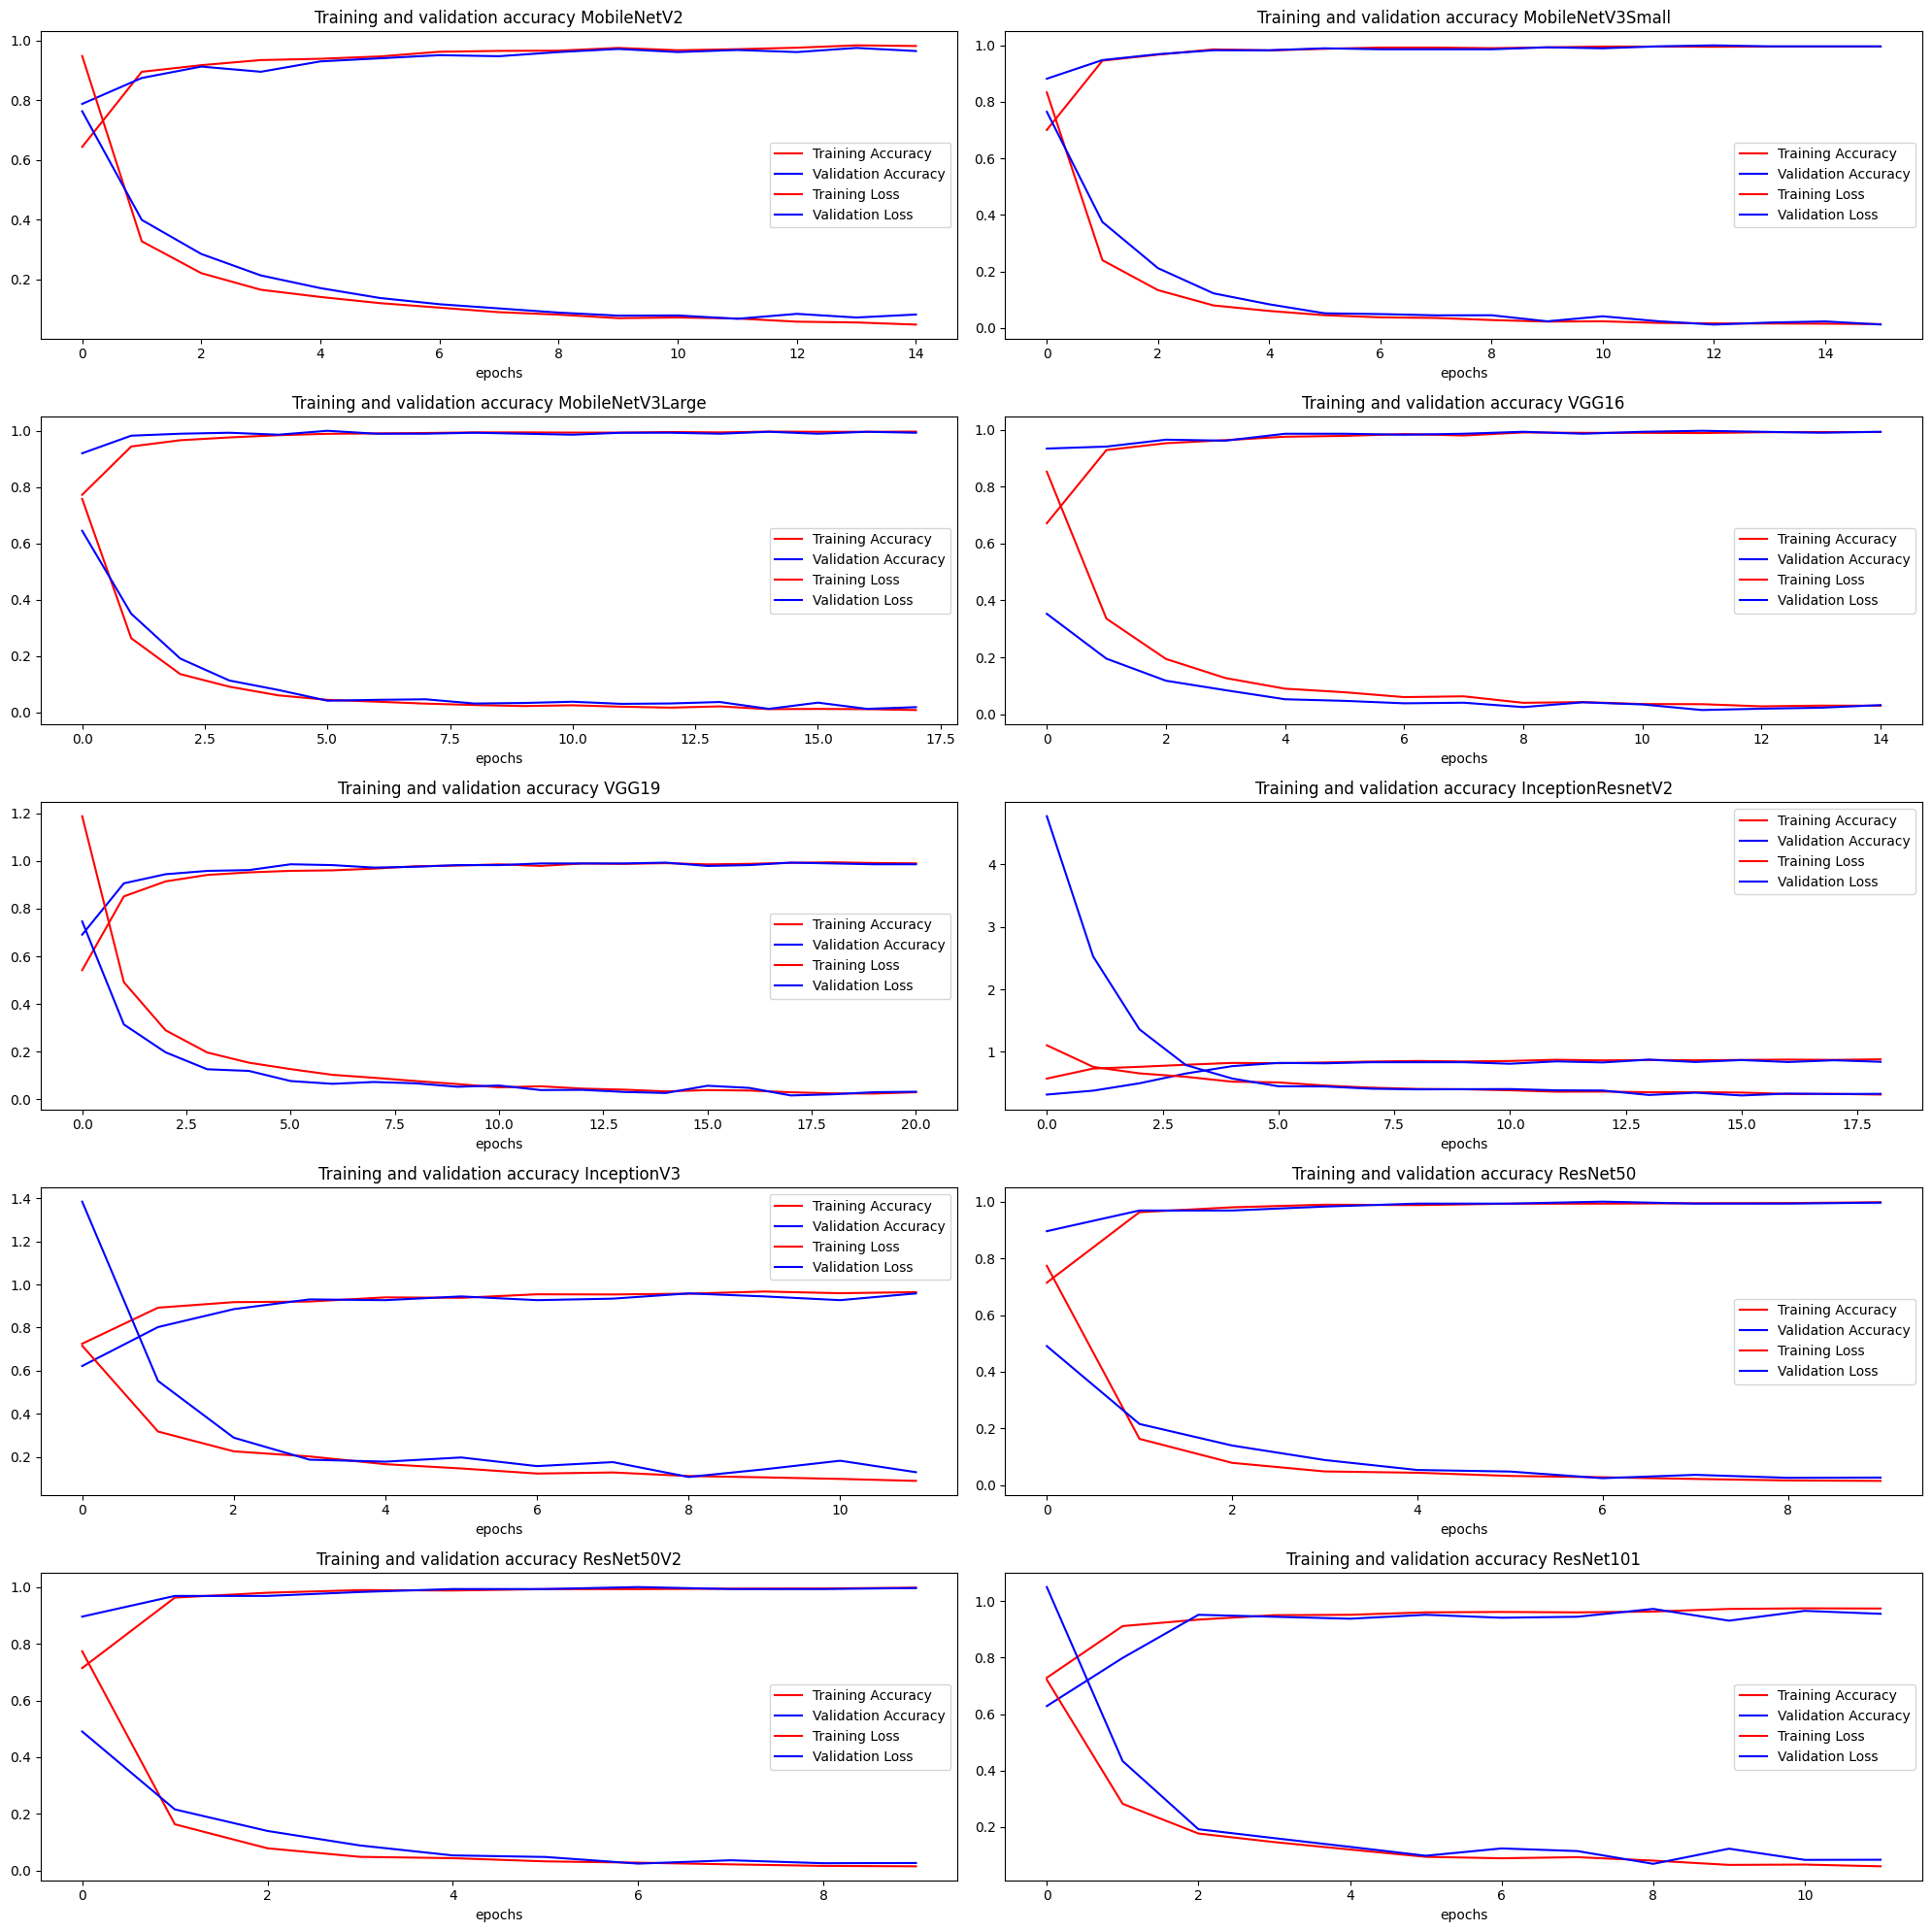

In [ ]:
fig, axes = plt.subplots(number_of_row, number_of_column, figsize=(20,20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

## MobileNetV2
# Get training and validation accuracies
acc = history_mobilenetv2.history['accuracy']
val_acc = history_mobilenetv2.history['val_accuracy']
loss = history_mobilenetv2.history['loss']
val_loss = history_mobilenetv2.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[0].set_title('Training and validation accuracy MobileNetV2')
axes[0].plot(epochs, acc, 'r', label="Training Accuracy")
axes[0].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[0].plot(epochs, loss, 'r', label="Training Loss")
axes[0].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[0].legend()
axes[0].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

##MobileNetV3Small
# Get training and validation accuracies
acc = history_mobilenetv3small.history['accuracy']
val_acc = history_mobilenetv3small.history['val_accuracy']
loss = history_mobilenetv3small.history['loss']
val_loss = history_mobilenetv3small.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[1].set_title('Training and validation accuracy MobileNetV3Small')
axes[1].plot(epochs, acc, 'r', label="Training Accuracy")
axes[1].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[1].plot(epochs, loss, 'r', label="Training Loss")
axes[1].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[1].legend()
axes[1].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## MobileNetV3Large
# Get training and validation accuracies
acc = history_mobilenetv3large.history['accuracy']
val_acc = history_mobilenetv3large.history['val_accuracy']
loss = history_mobilenetv3large.history['loss']
val_loss = history_mobilenetv3large.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[2].set_title('Training and validation accuracy MobileNetV3Large')
axes[2].plot(epochs, acc, 'r', label="Training Accuracy")
axes[2].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[2].plot(epochs, loss, 'r', label="Training Loss")
axes[2].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[2].legend()
axes[2].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## VGG16
# Get training and validation accuracies
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[3].set_title('Training and validation accuracy VGG16')
axes[3].plot(epochs, acc, 'r', label="Training Accuracy")
axes[3].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[3].plot(epochs, loss, 'r', label="Training Loss")
axes[3].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[3].legend()
axes[3].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## VGG19
# Get training and validation accuracies
acc = history_vgg19.history['accuracy']
val_acc = history_vgg19.history['val_accuracy']
loss = history_vgg19.history['loss']
val_loss = history_vgg19.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[4].set_title('Training and validation accuracy VGG19')
axes[4].plot(epochs, acc, 'r', label="Training Accuracy")
axes[4].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[4].plot(epochs, loss, 'r', label="Training Loss")
axes[4].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[4].legend()
axes[4].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## InceptionResnetV2
# Get training and validation accuracies
acc = history_inceptionresnetv2.history['accuracy']
val_acc = history_inceptionresnetv2.history['val_accuracy']
loss = history_inceptionresnetv2.history['loss']
val_loss = history_inceptionresnetv2.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[5].set_title('Training and validation accuracy InceptionResnetV2')
axes[5].plot(epochs, acc, 'r', label="Training Accuracy")
axes[5].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[5].plot(epochs, loss, 'r', label="Training Loss")
axes[5].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[5].legend()
axes[5].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## InceptionV3
# Get training and validation accuracies
acc = history_inceptionv3.history['accuracy']
val_acc = history_inceptionv3.history['val_accuracy']
loss = history_inceptionv3.history['loss']
val_loss = history_inceptionv3.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[6].set_title('Training and validation accuracy InceptionV3')
axes[6].plot(epochs, acc, 'r', label="Training Accuracy")
axes[6].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[6].plot(epochs, loss, 'r', label="Training Loss")
axes[6].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[6].legend()
axes[6].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## ResNet50
# Get training and validation accuracies
acc = history_resnet50.history['accuracy']
val_acc = history_resnet50.history['val_accuracy']
loss = history_resnet50.history['loss']
val_loss = history_resnet50.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[7].set_title('Training and validation accuracy ResNet50')
axes[7].plot(epochs, acc, 'r', label="Training Accuracy")
axes[7].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[7].plot(epochs, loss, 'r', label="Training Loss")
axes[7].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[7].legend()
axes[7].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## ResNet50V2
# Get training and validation accuracies
acc = history_resnet50.history['accuracy']
val_acc = history_resnet50.history['val_accuracy']
loss = history_resnet50.history['loss']
val_loss = history_resnet50.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[8].set_title('Training and validation accuracy ResNet50V2')
axes[8].plot(epochs, acc, 'r', label="Training Accuracy")
axes[8].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[8].plot(epochs, loss, 'r', label="Training Loss")
axes[8].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[8].legend()
axes[8].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## ResNet101
# Get training and validation accuracies
acc = history_resnet101.history['accuracy']
val_acc = history_resnet101.history['val_accuracy']
loss = history_resnet101.history['loss']
val_loss = history_resnet101.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[9].set_title('Training and validation accuracy ResNet101')
axes[9].plot(epochs, acc, 'r', label="Training Accuracy")
axes[9].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[9].plot(epochs, loss, 'r', label="Training Loss")
axes[9].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[9].legend()
axes[9].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)


plt.tight_layout()
plt.show()

###alternative

In [ ]:
# # Get training and validation accuracies
# acc = history_mobilenetv3large.history['accuracy']
# val_acc = history_mobilenetv3large.history['val_accuracy']
# loss = history_mobilenetv3large.history['loss']
# val_loss = history_mobilenetv3large.history['val_loss']
# # Get number of epochs
# epochs = range(len(acc))
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# fig.suptitle('Training and validation accuracy MobileNetV3Large')
# for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
#     ax[i].plot(epochs, data[0], 'r', label="Training " + label)
#     ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
#     ax[i].legend()
#     ax[i].set_xlabel('epochs')
# plt.show()

## y_true and y_pred

In [ ]:
# MobileNetV2
print("MobileNetV2")
y_true_mobilenetv2 = []
y_pred_mobilenetv2 = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_mobilenetv2.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_mobilenetv2.extend(true_labels)
    y_pred_mobilenetv2.extend(predicted_labels)

# MobileNetV3Small
print("MobileNetV3Small")
y_true_mobilenetv3small = []
y_pred_mobilenetv3small = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_mobilenetv3small.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_mobilenetv3small.extend(true_labels)
    y_pred_mobilenetv3small.extend(predicted_labels)

# MobileNetV3Large
print("MobileNetV3Large")
y_true_mobilenetv3large = []
y_pred_mobilenetv3large = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_mobilenetv3large.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_mobilenetv3large.extend(true_labels)
    y_pred_mobilenetv3large.extend(predicted_labels)

# VGG16
print("VGG16")
y_true_vgg16 = []
y_pred_vgg16 = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_vgg16.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_vgg16.extend(true_labels)
    y_pred_vgg16.extend(predicted_labels)

# VGG19
print("VGG19")
y_true_vgg19 = []
y_pred_vgg19 = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_vgg19.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_vgg19.extend(true_labels)
    y_pred_vgg19.extend(predicted_labels)

# InceptionResNetV2
print("InceptionResNetV2")
y_true_inceptionresnetv2 = []
y_pred_inceptionresnetv2 = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_inceptionresnetv2.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_inceptionresnetv2.extend(true_labels)
    y_pred_inceptionresnetv2.extend(predicted_labels)

# InceptionV3
print("InceptionV3")
y_true_inceptionv3 = []
y_pred_inceptionv3 = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_inceptionv3.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_inceptionv3.extend(true_labels)
    y_pred_inceptionv3.extend(predicted_labels)

# ResNet50
print("ResNet50")
y_true_resnet50 = []
y_pred_resnet50 = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_resnet50.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_resnet50.extend(true_labels)
    y_pred_resnet50.extend(predicted_labels)

# ResNet50V2
print("ResNet50V2")
y_true_resnet50v2 = []
y_pred_resnet50v2 = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_resnet50v2.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_resnet50v2.extend(true_labels)
    y_pred_resnet50v2.extend(predicted_labels)

# ResNet101
print("ResNet101")
y_true_resnet101 = []
y_pred_resnet101 = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_resnet101.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_resnet101.extend(true_labels)
    y_pred_resnet101.extend(predicted_labels)

MobileNetV2
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
MobileNetV3Small
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
MobileNetV3Large
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━

## training time

In [ ]:
# MobileNetV2 Training
trainingtime_mobilenetv2 = endtime_mobilenetv2 - starttime_mobilenetv2
print(f"MobileNetV2 training time: {trainingtime_mobilenetv2:.2f} seconds")
trainingtime_list.append(trainingtime_mobilenetv2)

print("-" * 10)

# MobileNetV3Small Training
trainingtime_mobilenetv3small = endtime_mobilenetv3small - starttime_mobilenetv3small
print(f"MobileNetV3Small training time: {trainingtime_mobilenetv3small:.2f} seconds")
trainingtime_list.append(trainingtime_mobilenetv3small)

print("-" * 10)

# MobileNetV3Large Training
trainingtime_mobilenetv3large = endtime_mobilenetv3large - starttime_mobilenetv3large
print(f"MobileNetV3Large training time: {trainingtime_mobilenetv3large:.2f} seconds")
trainingtime_list.append(trainingtime_mobilenetv3large)

print("-" * 10)

# VGG16 Training
trainingtime_vgg16 = endtime_vgg16 - starttime_vgg16
print(f"VGG16 training time: {trainingtime_vgg16:.2f} seconds")
trainingtime_list.append(trainingtime_vgg16)

print("-" * 10)

# VGG19 Training
trainingtime_vgg19 = endtime_vgg19 - starttime_vgg19
print(f"VGG19 training time: {trainingtime_vgg19:.2f} seconds")
trainingtime_list.append(trainingtime_vgg19)

print("-" * 10)

# InceptionResnetV2 Training
trainingtime_inceptionresnetv2 = endtime_inceptionresnetv2 - starttime_inceptionresnetv2
print(f"InceptionResnetV2 training time: {trainingtime_inceptionresnetv2:.2f} seconds")
trainingtime_list.append(trainingtime_inceptionresnetv2)

print("-" * 10)

# InceptionV3 Training
trainingtime_inceptionv3 = endtime_inceptionv3 - starttime_inceptionv3
print(f"InceptionV3 training time: {trainingtime_inceptionv3:.2f} seconds")
trainingtime_list.append(trainingtime_inceptionv3)

print("-" * 10)

# ResNet50 Training
trainingtime_resnet50 = endtime_resnet50 - starttime_resnet50
print(f"ResNet50 training time: {trainingtime_resnet50:.2f} seconds")
trainingtime_list.append(trainingtime_resnet50)

print("-" * 10)

# ResNet50V2 Training
trainingtime_resnet50v2 = endtime_resnet50v2 - starttime_resnet50v2
print(f"ResNet50 training time: {trainingtime_resnet50v2:.2f} seconds")
trainingtime_list.append(trainingtime_resnet50v2)

print("-" * 10)

# ResNet101 Training
trainingtime_resnet101 = endtime_resnet101 - starttime_resnet101
print(f"ResNet101 training time: {trainingtime_resnet101:.2f} seconds")
trainingtime_list.append(trainingtime_resnet101)

MobileNetV2 training time: 119.37 seconds
----------
MobileNetV3Small training time: 122.00 seconds
----------
MobileNetV3Large training time: 139.60 seconds
----------
VGG16 training time: 181.09 seconds
----------
VGG19 training time: 334.68 seconds
----------
InceptionResnetV2 training time: 267.38 seconds
----------
InceptionV3 training time: 119.69 seconds
----------
ResNet50 training time: 106.07 seconds
----------
ResNet50 training time: 94.28 seconds
----------
ResNet101 training time: 101.83 seconds


## Recall

In [ ]:
# MobileNetV2
print("MobileNetV2")
test_loss, test_acc = model_mobilenetv2.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# MobileNetV3Small
print("MobileNetV3Small")
test_loss, test_acc = model_mobilenetv3small.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# MobileNetV3Large
print("MobileNetV3Large")
test_loss, test_acc = model_mobilenetv3large.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# VGG16
print("VGG16")
test_loss, test_acc = model_vgg16.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# VGG19
print("VGG19")
test_loss, test_acc = model_vgg19.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# InceptionResNetV2
print("InceptionResNetV2")
test_loss, test_acc = model_inceptionresnetv2.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# InceptionV3
print("InceptionV3")
test_loss, test_acc = model_inceptionv3.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# ResNet50
print("ResNet50")
test_loss, test_acc = model_resnet50.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# ResNet50V2
print("ResNet50V2")
test_loss, test_acc = model_resnet50v2.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# ResNet101
print("ResNet101")
test_loss, test_acc = model_resnet101.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

MobileNetV2
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9975 - loss: 0.0353
Test Accuracy: 0.9942857027053833
Test Loss: 0.037591274827718735
----------
MobileNetV3Small
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 0.0043
Test Accuracy: 1.0
Test Loss: 0.00406560068950057
----------
MobileNetV3Large
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.9992 - loss: 0.0038
Test Accuracy: 0.9992856979370117
Test Loss: 0.004179832059890032
----------
VGG16
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.9924 - loss: 0.0159
Test Accuracy: 0.9957143068313599
Test Loss: 0.013199018314480782
----------
VGG19
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.9980 - loss: 0.0126
Test Accuracy: 0.9985714554786682
Test Loss: 0.011580982245504856
----------
InceptionResNetV2
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 271ms/step - accuracy: 0.8819 - loss: 0.2929
Test Accuracy: 0.8949999809265137
Test Loss: 0.26023828983306885
----------
InceptionV3
44/44 ━━━━━━━━━

## Precission

In [ ]:
# MobileNetV2
precision = precision_score(y_true_mobilenetv2, y_pred_mobilenetv2, average='weighted')
print(f"Precision MobileNetV2: {precision}")
precision_list.append(precision)

print("-" * 10)

# MobileNetV3Small
precision = precision_score(y_true_mobilenetv3small, y_pred_mobilenetv3small, average='weighted')
print(f"Precision MobileNetV3Small: {precision}")
precision_list.append(precision)

print("-" * 10)

# MobileNetV3Large
precision = precision_score(y_true_mobilenetv3large, y_pred_mobilenetv3large, average='weighted')
print(f"Precision MobileNetV3Large: {precision}")
precision_list.append(precision)

print("-" * 10)

# VGG16
precision = precision_score(y_true_vgg16, y_pred_vgg16, average='weighted')
print(f"Precision VGG16: {precision}")
precision_list.append(precision)

print("-" * 10)

# VGG19
precision = precision_score(y_true_vgg19, y_pred_vgg19, average='weighted')
print(f"Precision VGG19: {precision}")
precision_list.append(precision)

print("-" * 10)

# InceptionResNetV2
precision = precision_score(y_true_inceptionresnetv2, y_pred_inceptionresnetv2, average='weighted')
print(f"Precision InceptionResNetV2: {precision}")
precision_list.append(precision)

print("-" * 10)

# InceptionV3
precision = precision_score(y_true_inceptionv3, y_pred_inceptionv3, average='weighted')
print(f"Precision InceptionV3: {precision}")
precision_list.append(precision)

print("-" * 10)

# ResNet50
precision = precision_score(y_true_resnet50, y_pred_resnet50, average='weighted')
print(f"Precision ResNet50: {precision}")
precision_list.append(precision)

print("-" * 10)

# ResNet50V2
precision = precision_score(y_true_resnet50v2, y_pred_resnet50v2, average='weighted')
print(f"Precision ResNet50V2: {precision}")
precision_list.append(precision)

print("-" * 10)

# ResNet101
precision = precision_score(y_true_resnet101, y_pred_resnet101, average='weighted')
print(f"Precision ResNet101: {precision}")
precision_list.append(precision)

Precision MobileNetV2: 0.9615384615384616
----------
Precision MobileNetV3Small: 0.9968354430379746
----------
Precision MobileNetV3Large: 0.9937703141928494
----------
Precision VGG16: 0.9904271418683498
----------
Precision VGG19: 0.9840902069817733
----------
Precision InceptionResNetV2: 0.845823978888495
----------
Precision InceptionV3: 0.9220111116115214
----------
Precision ResNet50: 0.9904306692281377
----------
Precision ResNet50V2: 0.9519230769230769
----------
Precision ResNet101: 0.9394415680473372


## F1-score

In [ ]:
# MobileNetV2
f1 = f1_score(y_true_mobilenetv2, y_pred_mobilenetv2, average='weighted')
print(f"F1 Score MobileNetV2: {f1}")
f1score_list.append(f1)

print("-" * 10)

# MobileNetV3Small
f1 = f1_score(y_true_mobilenetv3small, y_pred_mobilenetv3small, average='weighted')
print(f"F1 Score MobileNetV3Small: {f1}")
f1score_list.append(f1)

print("-" * 10)

# MobileNetV3Large
f1 = f1_score(y_true_mobilenetv3large, y_pred_mobilenetv3large, average='weighted')
print(f"F1 Score MobileNetV3Large: {f1}")
f1score_list.append(f1)

print("-" * 10)

# VGG16
f1 = f1_score(y_true_vgg16, y_pred_vgg16, average='weighted')
print(f"F1 Score VGG16: {f1}")
f1score_list.append(f1)

print("-" * 10)

# VGG19
f1 = f1_score(y_true_vgg19, y_pred_vgg19, average='weighted')
print(f"F1 Score VGG19: {f1}")
f1score_list.append(f1)

print("-" * 10)

# InceptionResNetV2
f1 = f1_score(y_true_inceptionresnetv2, y_pred_inceptionresnetv2, average='weighted')
print(f"F1 Score InceptionResNetV2: {f1}")
f1score_list.append(f1)

print("-" * 10)

# InceptionV3
f1 = f1_score(y_true_inceptionv3, y_pred_inceptionv3, average='weighted')
print(f"F1 Score InceptionV3: {f1}")
f1score_list.append(f1)

print("-" * 10)

# ResNet50
f1 = f1_score(y_true_resnet50, y_pred_resnet50, average='weighted')
print(f"F1 Score ResNet50: {f1}")
f1score_list.append(f1)

print("-" * 10)

# ResNet50V2
f1 = f1_score(y_true_resnet50v2, y_pred_resnet50v2, average='weighted')
print(f"F1 Score ResNet50V2: {f1}")
f1score_list.append(f1)

print("-" * 10)

# ResNet101
f1 = f1_score(y_true_resnet101, y_pred_resnet101, average='weighted')
print(f"F1 Score ResNet101: {f1}")
f1score_list.append(f1)

F1 Score MobileNetV2: 0.9615384615384616
----------
F1 Score MobileNetV3Small: 0.996795247527927
----------
F1 Score MobileNetV3Large: 0.99359335839599
----------
F1 Score VGG16: 0.9903864490519206
----------
F1 Score VGG19: 0.9840134388950955
----------
F1 Score InceptionResNetV2: 0.836017308671305
----------
F1 Score InceptionV3: 0.9188198779084729
----------
F1 Score ResNet50: 0.9903870837159247
----------
F1 Score ResNet50V2: 0.9519230769230769
----------
F1 Score ResNet101: 0.9356278941184601


## Confusion matrix

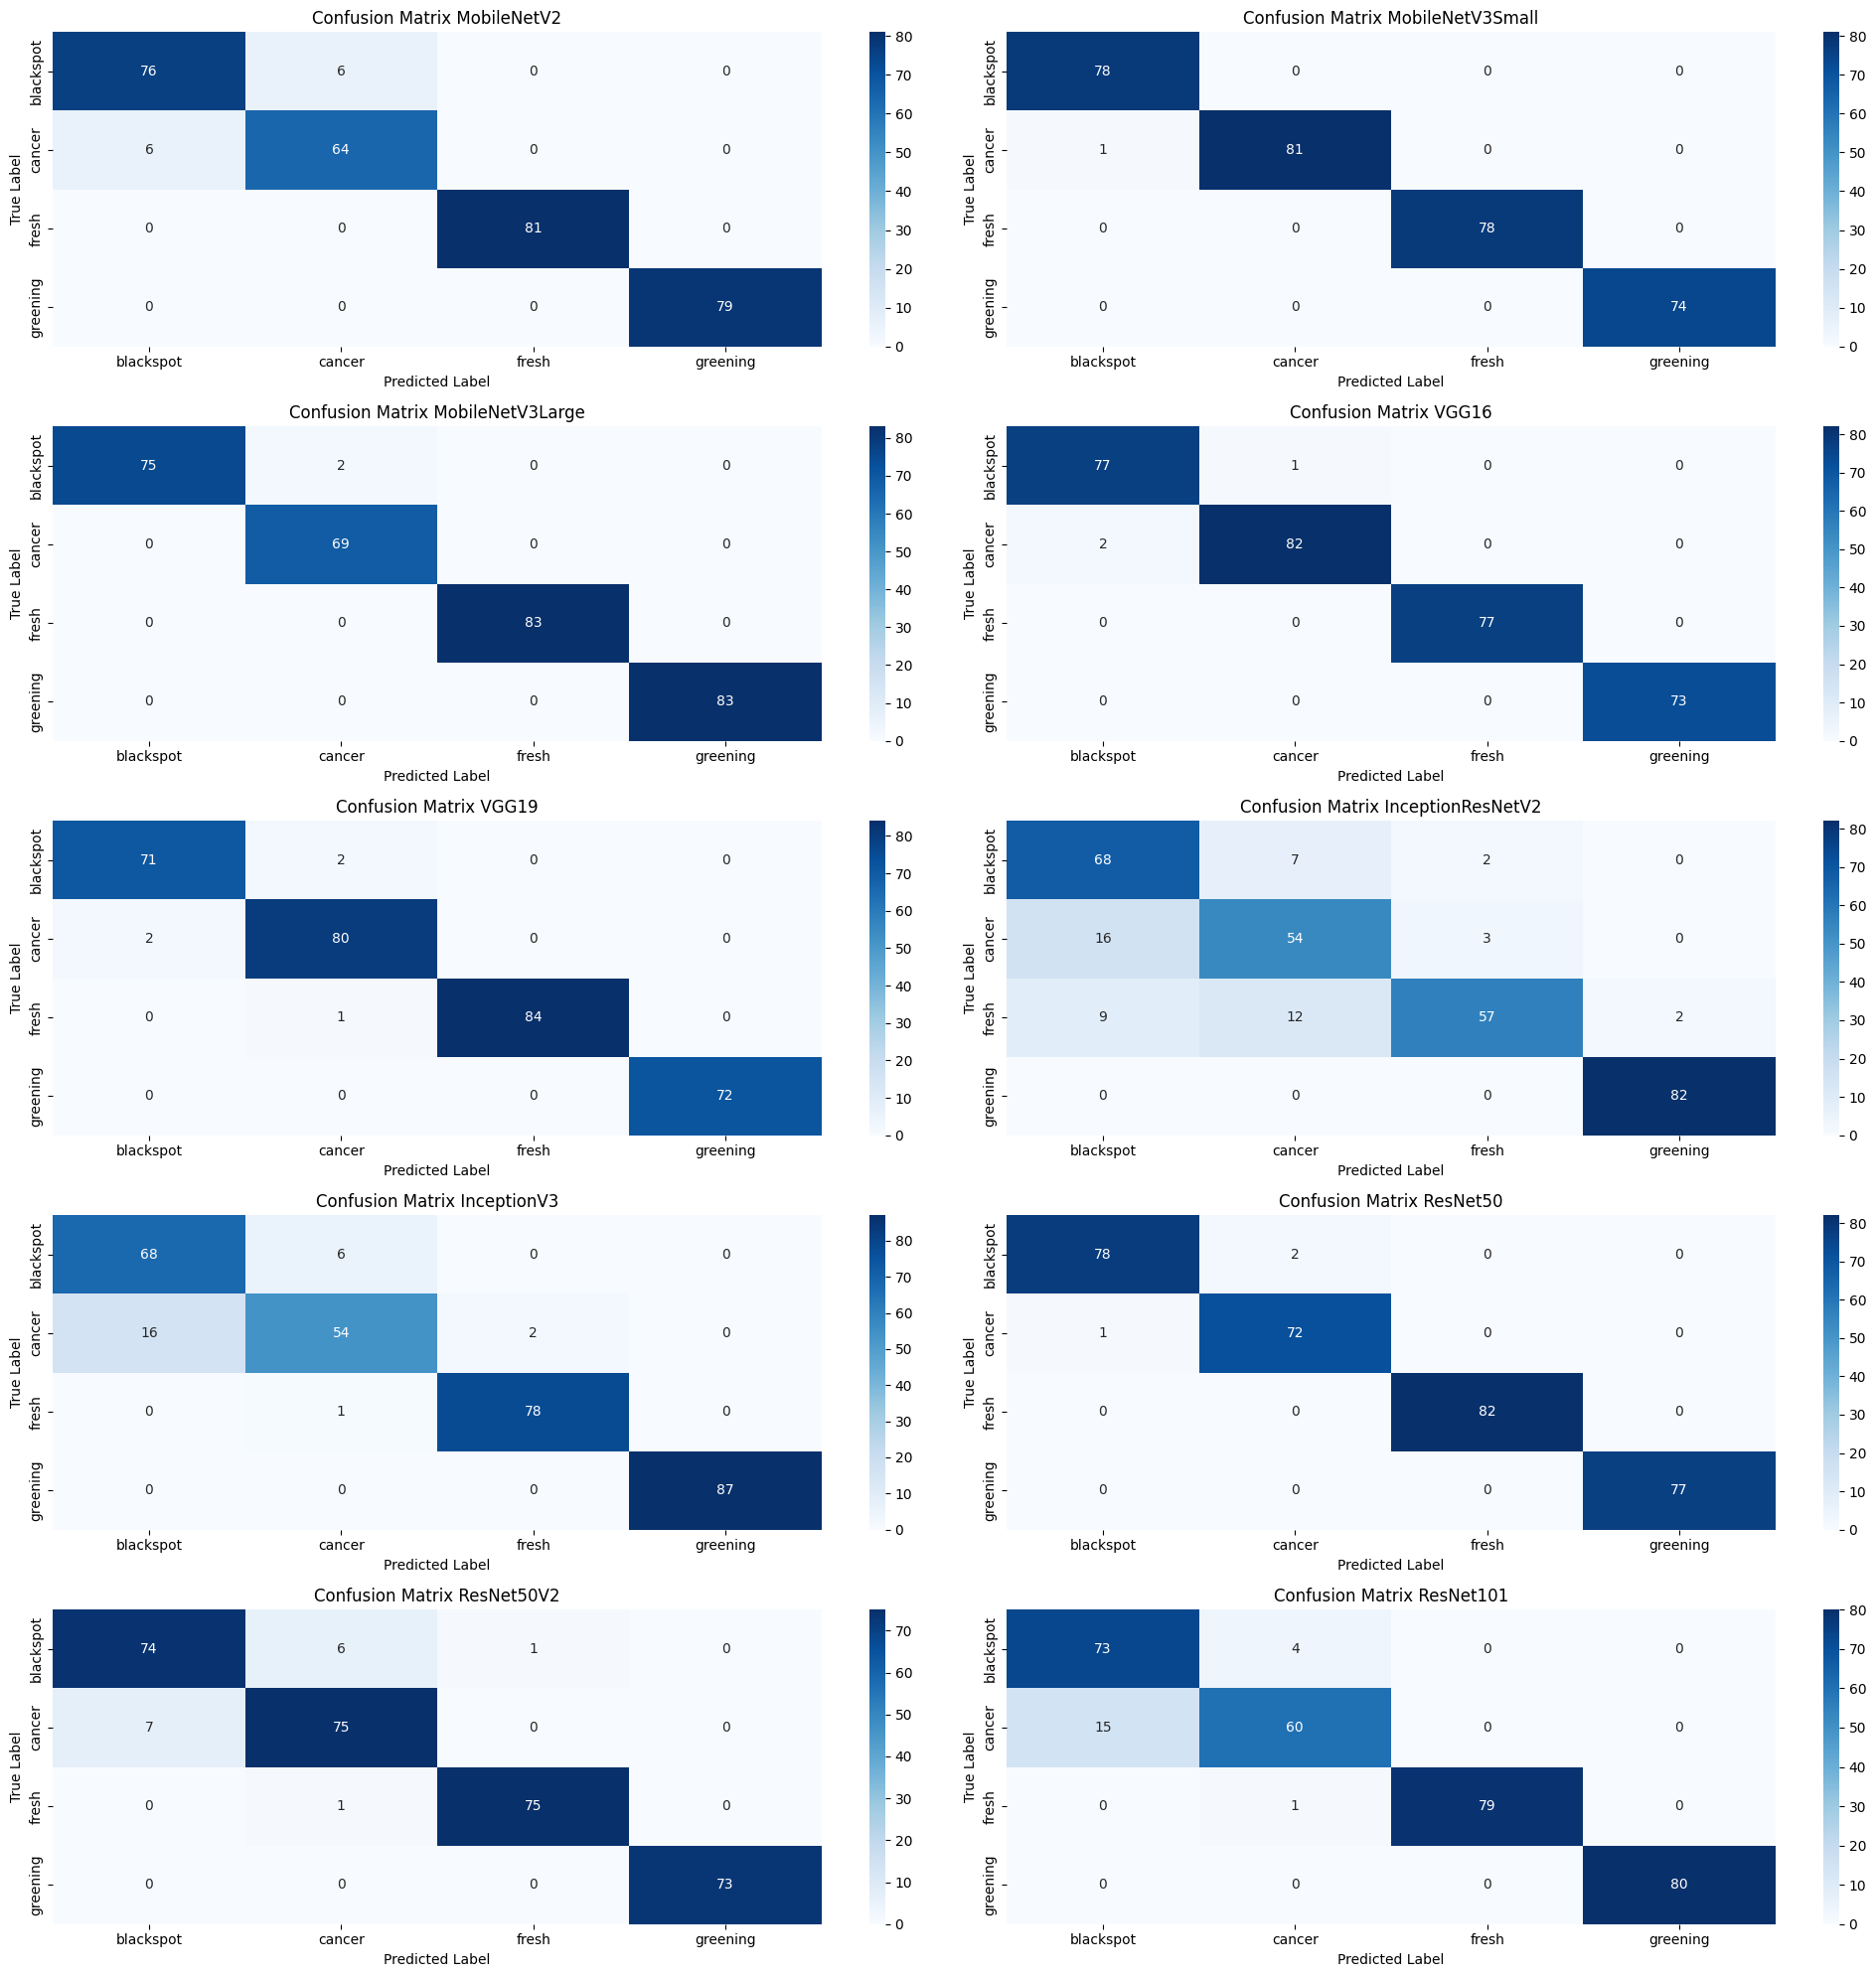

In [ ]:
## All architecture subplot
fig, axes = plt.subplots(number_of_row, number_of_column, figsize=(20, 20))

axes = axes.flatten()

## MobileNetV2
cm = confusion_matrix(y_true_mobilenetv2, y_pred_mobilenetv2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix MobileNetV2')


## MobileNetV3Small
cm = confusion_matrix(y_true_mobilenetv3small, y_pred_mobilenetv3small)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix MobileNetV3Small')

## MobileNetV3Large
cm = confusion_matrix(y_true_mobilenetv3large, y_pred_mobilenetv3large)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[2])
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')
axes[2].set_title('Confusion Matrix MobileNetV3Large')

## VGG16
cm = confusion_matrix(y_true_vgg16, y_pred_vgg16)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[3])
axes[3].set_xlabel('Predicted Label')
axes[3].set_ylabel('True Label')
axes[3].set_title('Confusion Matrix VGG16')

## VGG19
cm = confusion_matrix(y_true_vgg19, y_pred_vgg19)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[4])
axes[4].set_xlabel('Predicted Label')
axes[4].set_ylabel('True Label')
axes[4].set_title('Confusion Matrix VGG19')

## InceptionResNetV2
cm = confusion_matrix(y_true_inceptionresnetv2, y_pred_inceptionresnetv2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[5])
axes[5].set_xlabel('Predicted Label')
axes[5].set_ylabel('True Label')
axes[5].set_title('Confusion Matrix InceptionResNetV2')

## InceptionV3
cm = confusion_matrix(y_true_inceptionv3, y_pred_inceptionv3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[6])
axes[6].set_xlabel('Predicted Label')
axes[6].set_ylabel('True Label')
axes[6].set_title('Confusion Matrix InceptionV3')

## ResNet50
cm = confusion_matrix(y_true_resnet50, y_pred_resnet50)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[7])
axes[7].set_xlabel('Predicted Label')
axes[7].set_ylabel('True Label')
axes[7].set_title('Confusion Matrix ResNet50')

## ResNet50V2
cm = confusion_matrix(y_true_resnet50v2, y_pred_resnet50v2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[8])
axes[8].set_xlabel('Predicted Label')
axes[8].set_ylabel('True Label')
axes[8].set_title('Confusion Matrix ResNet50V2')

## ResNet101
cm = confusion_matrix(y_true_resnet101, y_pred_resnet101)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[9])
axes[9].set_xlabel('Predicted Label')
axes[9].set_ylabel('True Label')
axes[9].set_title('Confusion Matrix ResNet101')

fig.tight_layout()
plt.show()

## test case

Testing with image: /content/orange-diseases-dataset/test/greening/g (2).jpg


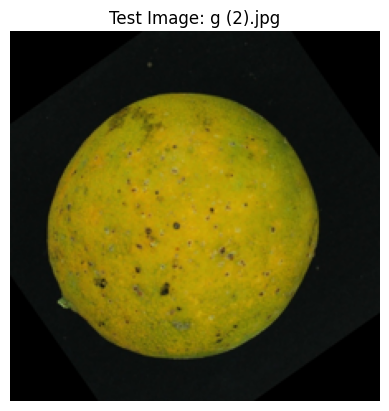



MobileNetV2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class index: 1
Predicted label: cancer
Prediction probabilities: [[0.20519437 0.40409    0.03903544 0.35168025]]
----------
MobileNetV3Small:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class index: 2
Predicted label: fresh
Prediction probabilities: [[2.6321376e-04 7.2662719e-05 8.2109082e-01 1.7857327e-01]]
----------
MobileNetV3Large:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class index: 3
Predicted label: greening
Prediction probabilities: [[6.5128900e-02 4.2041473e-04 3.5433349e-01 5.8011723e-01]]
----------
VGG16:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class index: 3
Predicted label: greening
Prediction probabilities: [[5.1584427e-04 2.3175830e-03 4.4041942e-03 9.9276239e-01]]
----------
VGG19:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
Predicted class index: 3
Predicted label: greening
----------
InceptionResnetV2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted class index: 3
Predicted label: greening
---------

In [ ]:
# Select one image from the test folder
test_dir = '/content/orange-diseases-dataset/test/'
# Get a list of all subdirectories (disease classes) in the test directory
disease_classes_test = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]

if not disease_classes_test:
    print("No disease class subdirectories found in the test directory.")
else:
    # Choose the first disease class found (you can modify this to choose a specific class)
    chosen_disease_class = disease_classes_test[2]
    chosen_class_path = os.path.join(test_dir, chosen_disease_class)

    # Get a list of all files in the chosen disease class directory
    image_files = [f for f in os.listdir(chosen_class_path) if f.lower().endswith(('.jpg', '.png'))]

    if not image_files:
        print(f"No images found in the directory: {chosen_class_path}")
    else:
        # Choose the first image file found (you can modify this to choose a specific image)
        test_image_path = os.path.join(chosen_class_path, image_files[0])
        print(f"Testing with image: {test_image_path}")

        # Load and preprocess the image
        img = load_and_resize_image(test_image_path)
        img_array = np.expand_dims(img, axis=0) / 255.0

        # Display the test image
        plt.imshow(img)
        plt.title(f"Test Image: {os.path.basename(test_image_path)}")
        plt.axis('off')
        plt.show()

        # Make predictions with each model
        print("\n")
        # MobileNetV2
        print("MobileNetV2:")
        predictions_mobilenetv2 = model_mobilenetv2.predict(img_array)
        predicted_class_mobilenetv2 = np.argmax(predictions_mobilenetv2, axis=1)[0]
        predicted_label_mobilenetv2 = class_names[predicted_class_mobilenetv2]
        print(f"Predicted class index: {predicted_class_mobilenetv2}")
        print(f"Predicted label: {predicted_label_mobilenetv2}")
        print(f"Prediction probabilities: {predictions_mobilenetv2}")

        print("-" * 10)

        # MobileNetV3Small
        print("MobileNetV3Small:")
        predictions_mobilenetv3small = model_mobilenetv3small.predict(img_array)
        predicted_class_mobilenetv3small = np.argmax(predictions_mobilenetv3small, axis=1)[0]
        predicted_label_mobilenetv3small = class_names[predicted_class_mobilenetv3small]
        print(f"Predicted class index: {predicted_class_mobilenetv3small}")
        print(f"Predicted label: {predicted_label_mobilenetv3small}")
        print(f"Prediction probabilities: {predictions_mobilenetv3small}")

        print("-" * 10)

        # MobileNetV3Large
        print("MobileNetV3Large:")
        predictions_mobilenetv3large = model_mobilenetv3large.predict(img_array)
        predicted_class_mobilenetv3large = np.argmax(predictions_mobilenetv3large, axis=1)[0]
        predicted_label_mobilenetv3large = class_names[predicted_class_mobilenetv3large]
        print(f"Predicted class index: {predicted_class_mobilenetv3large}")
        print(f"Predicted label: {predicted_label_mobilenetv3large}")
        print(f"Prediction probabilities: {predictions_mobilenetv3large}")

        print("-" * 10)

        # VGG16
        print("VGG16:")
        predictions_vgg16 = model_vgg16.predict(img_array)
        predicted_class_vgg16 = np.argmax(predictions_vgg16, axis=1)[0]
        predicted_label_vgg16 = class_names[predicted_class_vgg16]
        print(f"Predicted class index: {predicted_class_vgg16}")
        print(f"Predicted label: {predicted_label_vgg16}")
        print(f"Prediction probabilities: {predictions_vgg16}")

        print("-" * 10)

        # VGG19
        print("VGG19:")
        predictions_vgg19 = model_vgg19.predict(img_array)
        predicted_class_vgg19 = np.argmax(predictions_vgg19, axis=1)[0]
        predicted_label_vgg19 = class_names[predicted_class_vgg19]
        print(f"Predicted class index: {predicted_class_vgg19}")
        print(f"Predicted label: {predicted_label_vgg19}")

        print("-" * 10)

        # InceptionResnetV2
        print("InceptionResnetV2:")
        predictions_inceptionresnetv2 = model_inceptionresnetv2.predict(img_array)
        predicted_class_inceptionresnetv2 = np.argmax(predictions_inceptionresnetv2, axis=1)[0]
        predicted_label_inceptionresnetv2 = class_names[predicted_class_inceptionresnetv2]
        print(f"Predicted class index: {predicted_class_inceptionresnetv2}")
        print(f"Predicted label: {predicted_label_inceptionresnetv2}")

        print("-" * 10)

        # InceptionV3
        print("InceptionV3:")
        predictions_inceptionv3 = model_inceptionv3.predict(img_array)
        predicted_class_inceptionv3 = np.argmax(predictions_inceptionv3, axis=1)[0]
        predicted_label_inceptionv3 = class_names[predicted_class_inceptionv3]
        print(f"Predicted class index: {predicted_class_inceptionv3}")
        print(f"Predicted label: {predicted_label_inceptionv3}")

        print("-" * 10)

        # ResNet50
        print("ResNet50:")
        predictions_resnet50 = model_resnet50.predict(img_array)
        predicted_class_resnet50 = np.argmax(predictions_resnet50, axis=1)[0]
        predicted_label_resnet50 = class_names[predicted_class_resnet50]
        print(f"Predicted class index: {predicted_class_resnet50}")
        print(f"Predicted label: {predicted_label_resnet50}")

        print("-" * 10)

        # ResNet50V2
        print("ResNet50V2:")
        predictions_resnet50v2 = model_resnet50v2.predict(img_array)
        predicted_class_resnet50v2 = np.argmax(predictions_resnet50v2, axis=1)[0]
        predicted_label_resnet50v2 = class_names[predicted_class_resnet50v2]
        print(f"Predicted class index: {predicted_class_resnet50v2}")
        print(f"Predicted label: {predicted_label_resnet50v2}")

        print("-" * 10)

        # ResNet101
        print("ResNet101:")
        predictions_resnet101 = model_resnet101.predict(img_array)
        predicted_class_resnet101 = np.argmax(predictions_resnet101, axis=1)[0]
        predicted_label_resnet101 = class_names[predicted_class_resnet101]
        print(f"Predicted class index: {predicted_class_resnet101}")
        print(f"Predicted label: {predicted_label_resnet101}")

## Performance Table

In [ ]:
import pandas as pd
import numpy as np

# Function to get trainable and non-trainable parameters
def get_model_params(model):
    trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
    return trainable_params, non_trainable_params

# Extracting the number of epochs the model was actually trained for (due to early stopping)
epochs_mobilenetv2 = len(history_mobilenetv2.history['accuracy'])
epochs_mobilenetv3small = len(history_mobilenetv3small.history['accuracy'])
epochs_mobilenetv3large = len(history_mobilenetv3large.history['accuracy'])
epochs_vgg16 = len(history_vgg16.history['accuracy'])
epochs_vgg19 = len(history_vgg19.history['accuracy'])
epochs_inceptionresnetv2 = len(history_inceptionresnetv2.history['accuracy'])
epochs_inceptionv3 = len(history_inceptionv3.history['accuracy'])
epochs_resnet50 = len(history_resnet50.history['accuracy'])
epochs_resnet50v2 = len(history_resnet50v2.history['accuracy'])
epochs_resnet101 = len(history_resnet101.history['accuracy'])


# Get trainable and non-trainable parameters for each model
trainable_mobilenetv2, non_trainable_mobilenetv2 = get_model_params(model_mobilenetv2)
trainable_mobilenetv3small, non_trainable_mobilenetv3small = get_model_params(model_mobilenetv3small)
trainable_mobilenetv3large, non_trainable_mobilenetv3large = get_model_params(model_mobilenetv3large)
trainable_vgg16, non_trainable_vgg16 = get_model_params(model_vgg16)
trainable_vgg19, non_trainable_vgg19 = get_model_params(model_vgg19)
trainable_inceptionresnetv2, non_trainable_inceptionresnetv2 = get_model_params(model_inceptionresnetv2)
trainable_inceptionv3, non_trainable_inceptionv3 = get_model_params(model_inceptionv3)
trainable_resnet50, non_trainable_resnet50 = get_model_params(model_resnet50)
trainable_resnet50v2, non_trainable_resnet50v2 = get_model_params(model_resnet50v2)
trainable_resnet101, non_trainable_resnet101 = get_model_params(model_resnet101)

# Create the DataFrame
data = {
    'Architecture': ['MobileNetV2', 'MobileNetV3Small', 'MobileNetV3Large', 'VGG16', 'VGG19', 'InceptionResNetV2', 'InceptionV3', 'ResNet50', 'ResNet50V2', 'ResNet101'],
    'Epochs': [epochs_mobilenetv2, epochs_mobilenetv3small, epochs_mobilenetv3large, epochs_vgg16, epochs_vgg19, epochs_inceptionresnetv2, epochs_inceptionv3, epochs_resnet50, epochs_resnet50v2, epochs_resnet101],
    'Trainable Param': [trainable_mobilenetv2, trainable_mobilenetv3small, trainable_mobilenetv3large, trainable_vgg16, trainable_vgg19, trainable_inceptionresnetv2, trainable_inceptionv3, trainable_resnet50, trainable_resnet50v2, trainable_resnet101],
    'Non-trainable Param': [non_trainable_mobilenetv2, non_trainable_mobilenetv3small, non_trainable_mobilenetv3large, non_trainable_vgg16, non_trainable_vgg19, non_trainable_inceptionresnetv2, non_trainable_inceptionv3, non_trainable_resnet50, non_trainable_resnet50v2, non_trainable_resnet101],
    'Training Time (s)': trainingtime_list,
    'Acc': [history_mobilenetv2.history['accuracy'][-1], history_mobilenetv3small.history['accuracy'][-1], history_mobilenetv3large.history['accuracy'][-1], history_vgg16.history['accuracy'][-1], history_vgg19.history['accuracy'][-1], history_inceptionresnetv2.history['accuracy'][-1], history_inceptionv3.history['accuracy'][-1], history_resnet50.history['accuracy'][-1], history_resnet50v2.history['accuracy'][-1], history_resnet101.history['accuracy'][-1]],
    'Val_Acc': [history_mobilenetv2.history['val_accuracy'][-1], history_mobilenetv3small.history['val_accuracy'][-1], history_mobilenetv3large.history['val_accuracy'][-1], history_vgg16.history['val_accuracy'][-1], history_vgg19.history['val_accuracy'][-1], history_inceptionresnetv2.history['val_accuracy'][-1], history_inceptionv3.history['val_accuracy'][-1], history_resnet50.history['val_accuracy'][-1], history_resnet50v2.history['val_accuracy'][-1], history_resnet101.history['val_accuracy'][-1]],
    'Loss': [history_mobilenetv2.history['loss'][-1], history_mobilenetv3small.history['loss'][-1], history_mobilenetv3large.history['loss'][-1], history_vgg16.history['loss'][-1], history_vgg19.history['loss'][-1], history_inceptionresnetv2.history['loss'][-1], history_inceptionv3.history['loss'][-1], history_resnet50.history['loss'][-1], history_resnet50v2.history['loss'][-1], history_resnet101.history['loss'][-1]],
    'Val_Loss': [history_mobilenetv2.history['val_loss'][-1], history_mobilenetv3small.history['val_loss'][-1], history_mobilenetv3large.history['val_loss'][-1], history_vgg16.history['val_loss'][-1], history_vgg19.history['val_loss'][-1], history_inceptionresnetv2.history['val_loss'][-1], history_inceptionv3.history['val_loss'][-1], history_resnet50.history['val_loss'][-1], history_resnet50v2.history['val_loss'][-1], history_resnet101.history['val_loss'][-1]],
    'Recall': [recall_list[0][0], recall_list[1][0], recall_list[2][0], recall_list[3][0], recall_list[4][0], recall_list[5][0], recall_list[6][0], recall_list[7][0], recall_list[8][0], recall_list[9][0]],
    'Precision': precision_list,
    'F1-score': f1score_list
}

df_performance = pd.DataFrame(data)
df_performance['Training Time (s)'] = df_performance['Training Time (s)'].round(2)
df_performance['Acc'] = df_performance['Acc'].round(4)
df_performance['Val_Acc'] = df_performance['Val_Acc'].round(4)
df_performance['Loss'] = df_performance['Loss'].round(4)
df_performance['Val_Loss'] = df_performance['Val_Loss'].round(4)
df_performance['Recall'] = df_performance['Recall'].round(4)
df_performance['Precision'] = df_performance['Precision'].round(4)
df_performance['F1-score'] = df_performance['F1-score'].round(4)


print("Performance Table:")
df_performance.head(10)

Performance Table:


Architecture  Epochs  Trainable Param  Non-trainable Param  \
0        MobileNetV2      15           371908              2260544   
1   MobileNetV3Small      16           190276               940272   
2   MobileNetV3Large      18           289348              2998272   
3              VGG16      15           173764             14715712   
4              VGG19      21           173764             20025408   
5  InceptionResNetV2      19           437956             54339808   
6        InceptionV3      12           570052             21806880   
7           ResNet50      10           570052             23591808   
8         ResNet50V2      10           570052             23568896   
9          ResNet101      12           570052             23568896   

   Training Time (s)     Acc  Val_Acc    Loss  Val_Loss  Recall  Precision  \
0             119.37  0.9821   0.9653  0.0489    0.0827  0.9943     0.9615   
1             122.00  0.9957   0.9965  0.0132    0.0119  1.0000     0.9968   
2             139.60  0.9971   0.9931  0.0086    0.0188  0.9993     0.9938   
3             181.09  0.9921   0.9931  0.0297    0.0319  0.9957     0.9904   
4             334.68  0.9900   0.9861  0.0299    0.0321  0.9986     0.9841   
5             267.38  0.8800   0.8403  0.3158    0.3275  0.8950     0.8458   
6             119.69  0.9643   0.9583  0.0883    0.1287  0.9800     0.9220   
7             106.07  0.9979   0.9965  0.0151    0.0268  0.9957     0.9904   
8              94.28  0.9657   0.9479  0.0884    0.1084  0.9707     0.9519   
9             101.83  0.9736   0.9549  0.0611    0.0843  0.9864     0.9394   

   F1-score  
0    0.9615  
1    0.9968  
2    0.9936  
3    0.9904  
4    0.9840  
5    0.8360  
6    0.9188  
7    0.9904  
8    0.9519  
9    0.9356

# save model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_mobilenetv3large)
tflite_model = converter.convert()

# Save the model to a .tflite file
tflite_model_name = 'orange_disease_classifier_mobilenetv3large.tflite'
with open(tflite_model_name, 'wb') as f:
  f.write(tflite_model)

print(f"Model saved to {tflite_model_name}")


Saved artifact at '/tmp/tmpew2umby8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_553')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135636625749392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135634537814864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135634537819280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135636625749776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135634537819664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135634537820432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135634537820816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135634537821392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135634537821200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135634537820240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1356345378